In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import itertools as it
from tqdm.notebook import tqdm

In [2]:
import seaborn as sns
%pylab inline
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numba

In [4]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    
    else:
        return(np.exp(np.log(lmbda*y + 1) / lmbda))

In [5]:
# pd.read_excel?

In [6]:
crime = pd.read_excel('crime.xlsx', sheet_name='pandas')
crime.set_index(pd.to_datetime(crime.month), inplace=True)
crime.drop(['month'], axis=1, inplace=True)
crime

,Total_crimes,Serious_and_especially_serious,Causing_huge_damage,Ecological,Terrorism,Extremism,Murder,Serious_harm_to_health,Rape_assault,Razboy,Grabezh,Theft,Vehicle_theft,Fraud_scam,Hooligan,Drugs,Weapons
month,,,,,,,,,,,,,,,,,
2003-01-01,214587,88203,20162,1216,630,13,2749,5559,574,3698,16455,81014,3549,7731,10560,16006,4661
2003-02-01,221928,88863,20889,1701,678,5,2444,4732,515,3678,15724,95970,3697,7607,10816,16839,5364
2003-03-01,248452,101349,24053,1817,809,10,2864,4851,560,4406,15674,79420,4327,9437,11813,20176,5938
2003-04-01,236299,91625,19754,2449,892,10,2919,4722,668,4322,14440,95215,5345,7824,12636,16614,5230
2003-05-01,230931,89615,17519,3530,796,20,2713,4895,688,3781,14209,94505,6374,7122,12234,14413,5112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,166208,38967,64283,1858,122,48,555,1570,306,537,3612,67006,1903,21557,155,15100,1945
2019-10-01,199038,53319,81775,2322,111,52,668,1846,223,652,3984,81053,2197,27980,180,20510,1744
2019-11-01,148104,31652,49623,1581,149,27,622,1467,246,507,3403,57434,1344,19794,132,11067,1742


## Будем рассматривать данные по преступлениям, связанным с оборотом оружия

In [7]:
CATEGORY = 'Weapons'

In [8]:
data = crime[[CATEGORY]]
data.columns = ['amount']
data['amount'] = data.amount.astype(float)
data

,amount
month,
2003-01-01,4661.0
2003-02-01,5364.0
2003-03-01,5938.0
2003-04-01,5230.0
2003-05-01,5112.0
...,...
2019-09-01,1945.0
2019-10-01,1744.0
2019-11-01,1742.0


### Строим график

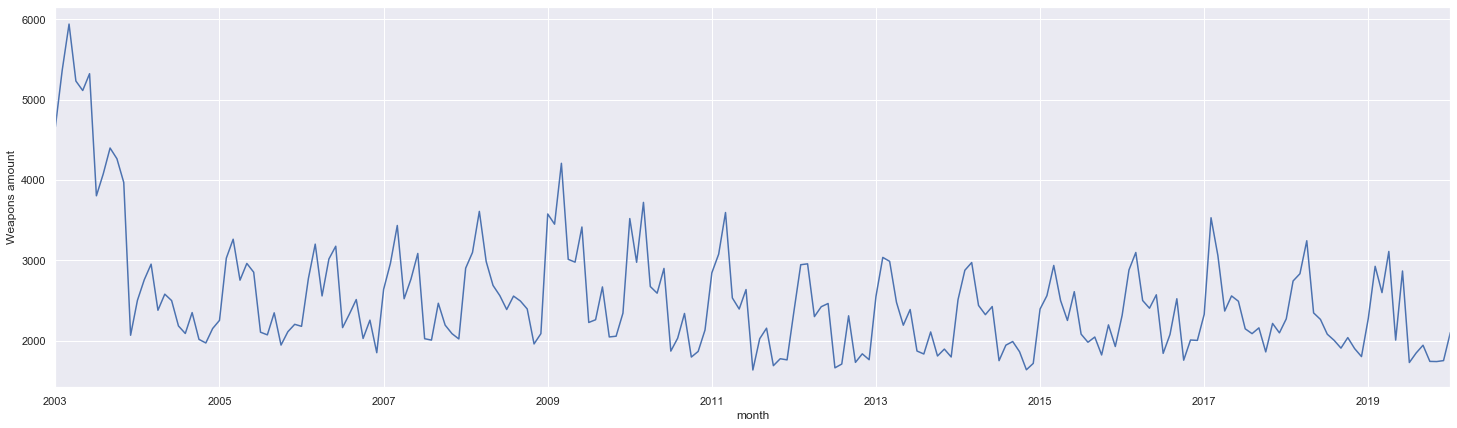

Стандартное отклонение: 733.17


In [9]:
plt.figure(figsize(25, 7))
data.amount.plot()
plt.ylabel('%s amount' % CATEGORY)
plt.show()

print('Стандартное отклонение: %.2f' % data.amount.std())

### Проверка стационарности и STL-декомпозиция ряда:

<Figure size 1080x720 with 0 Axes>

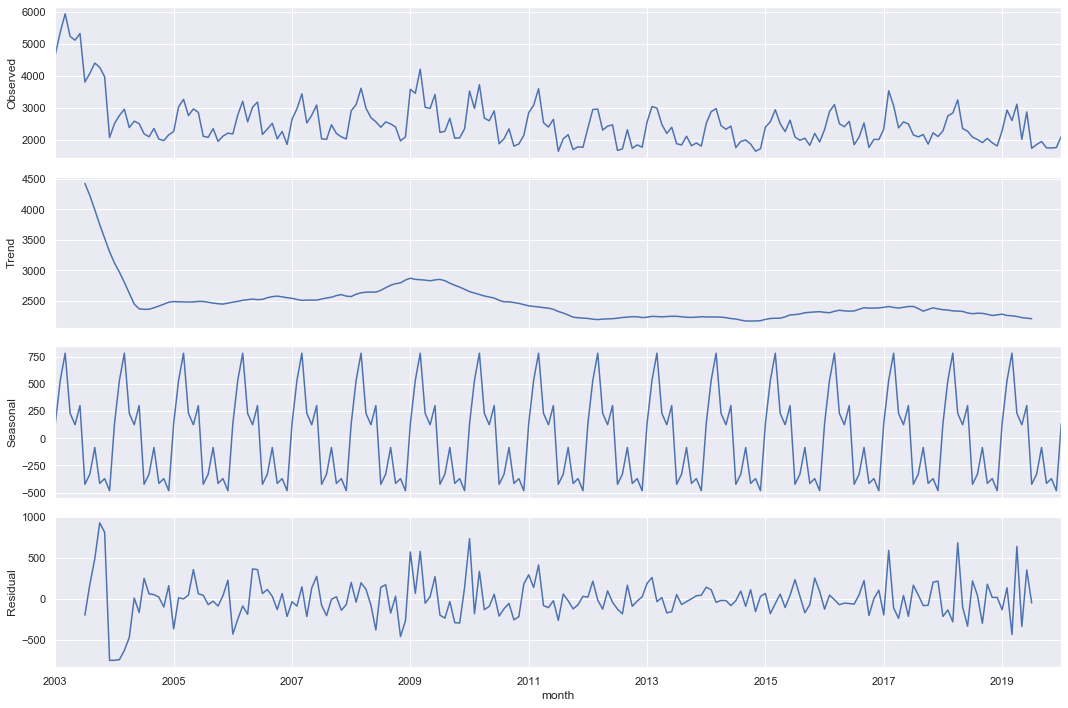

Критерий Дики-Фуллера: p=0.003824


In [10]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.amount).plot()
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.amount)[1])

Смотрим на значение $p_{value} = 0.004$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности ряда отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности

Сразу видны следующие особенности данных:
* убывающий тренд
* Большая дисперсия
* периодичность (период = 12 месяцев)
* Остатки вроде бы не имеют структуры

In [11]:
season = 12

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [12]:
NEED = False

In [13]:
if NEED:
    data['amount_boxcox'], lmbda = stats.boxcox(data.amount)
else:
    data['amount_boxcox'], lmbda = data.amount, 1

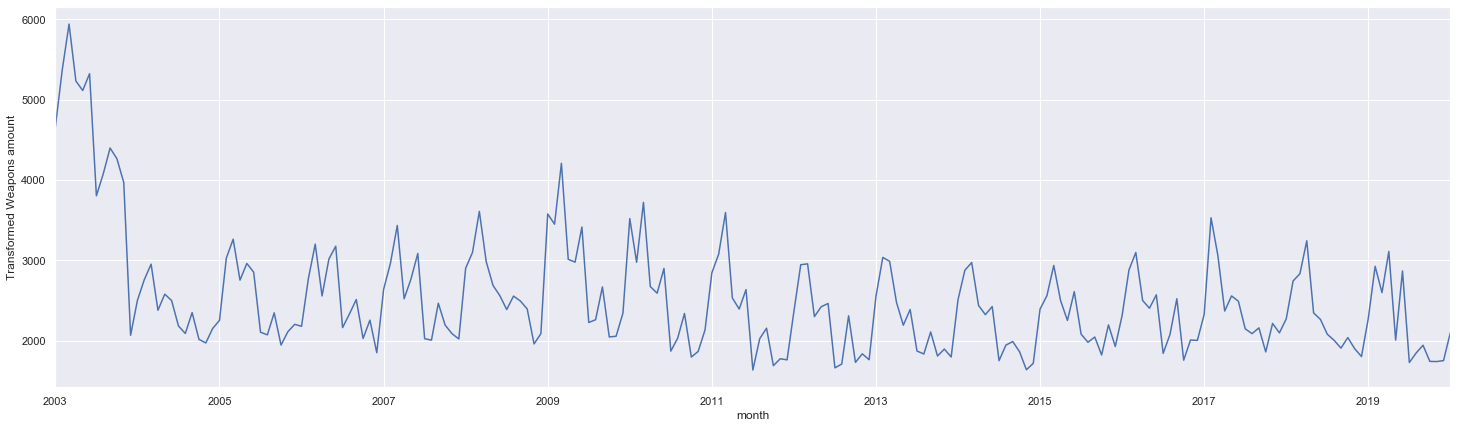

Оптимальный параметр преобразования Бокса-Кокса: 1.000000
Критерий Дики-Фуллера: p = 0.003824


In [14]:
plt.figure(figsize(25, 7))
data.amount_boxcox.plot()
plt.ylabel('Transformed %s amount' % CATEGORY)
plt.show()

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount_boxcox)[1])

In [15]:
print('Стандартное отклонение: %.7f' % data.amount_boxcox.std())

Стандартное отклонение: 733.1698902


Если мы применим преобразование Бокса-Кокса, то у нас дисперсия уйдет в ноль. Оно как бы хорошо, но модель из-за этого вообще не сможет обучаться, придется применять `костыли`

Смотрим на значение $p_{value}$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности ряда отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности

Если остатки не имеют структуры, то все хорошо. Если не удалось избавиться от тренда, то пробуем применить ***сезонное дифференцирование***

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и визуально в данных виден тренд. Попробуем сначала ***сезонное дифференцирование*** и позже сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

<Figure size 1080x720 with 0 Axes>

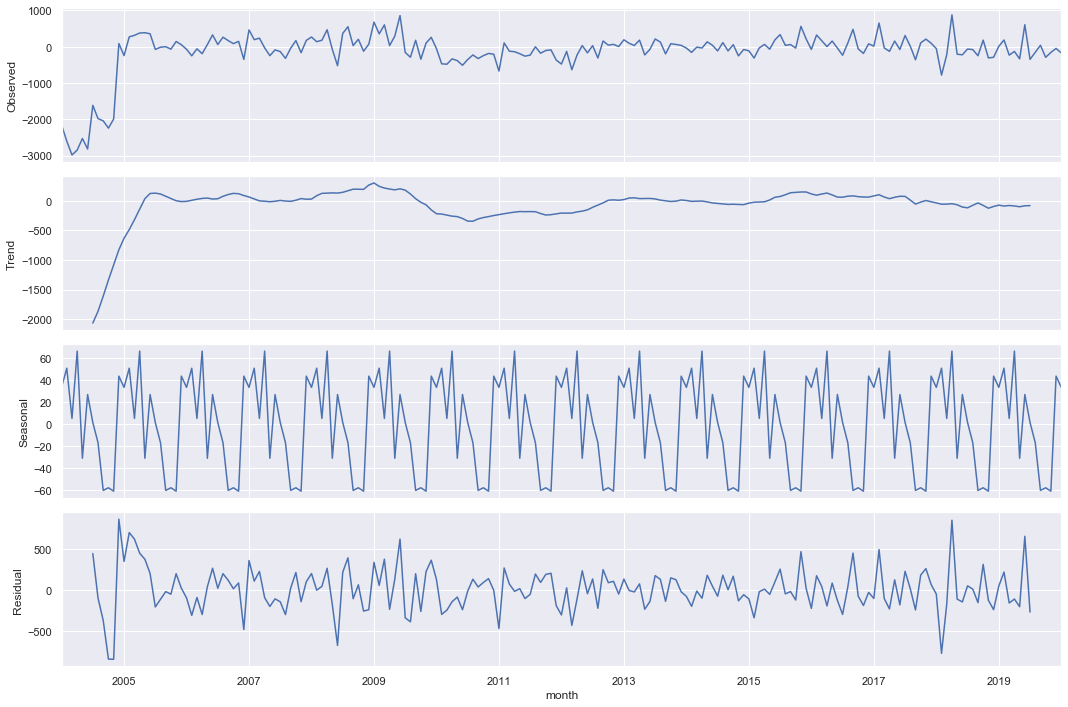

Критерий Дики-Фуллера: p = 0.000725


In [16]:
data['amount_boxcox_diff'] = data.amount_boxcox - data.amount_boxcox.shift(season)

plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.amount_boxcox_diff[season:]).plot()
plt.show()

print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount_boxcox_diff[season:])[1])

Смотрим на значение $p_{value}$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности

Если остатки не имеют структуры, то все хорошо. Если не удалось избавиться от тренда, то пробуем применить ***обычное дифференцирование***

C:\Users\tsark\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<Figure size 1080x720 with 0 Axes>

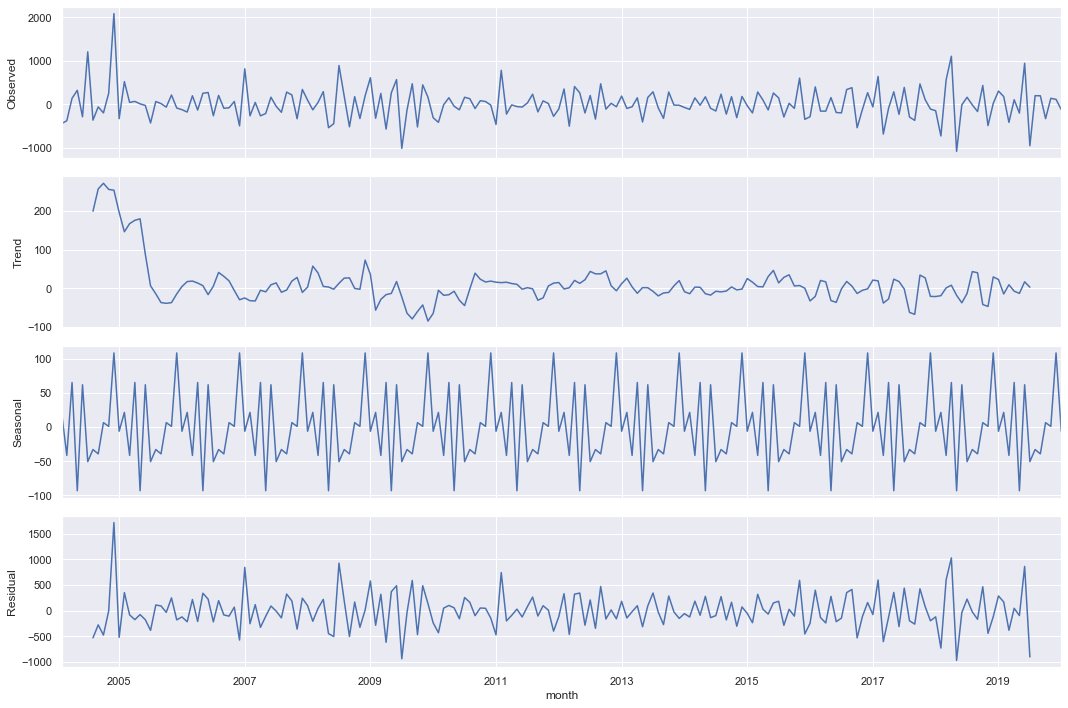

Критерий Дики-Фуллера: p = 0.000000


In [55]:
data['amount_boxcox_diff2'] = data.amount_boxcox_diff - data.amount_boxcox_diff.shift(1)

plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.amount_boxcox_diff2[season + 1:]).plot()   
plt.show()

print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount_boxcox_diff2[season + 1:])[1])

Смотрим на значение $p_{value}$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности ряда отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности ряда

Если остатки не имеют структуры, то все хорошо.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

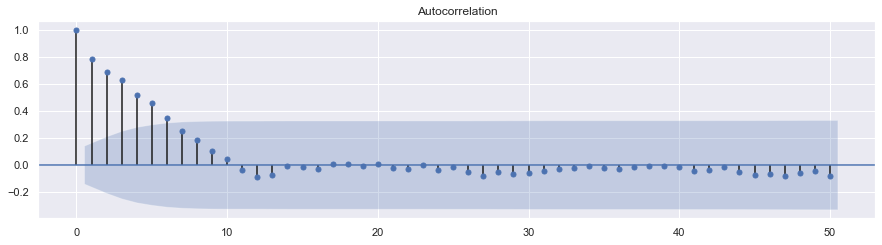

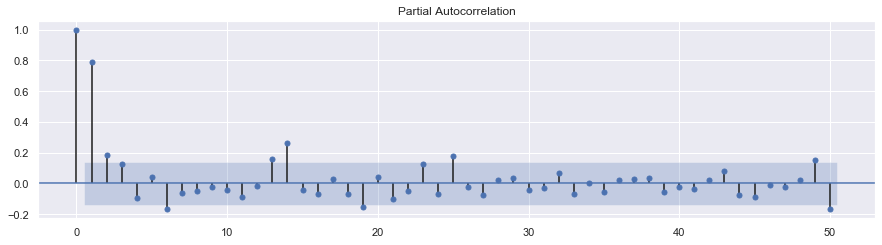

In [18]:
plt.figure(figsize(15, 8))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(
    data.amount_boxcox_diff[season:].values.squeeze(), # внимательнее amount_boxcox_diff[season:]
    lags=50,
    ax=ax)
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    data.amount_boxcox_diff[season:].values.squeeze(), # внимательнее amount_boxcox_diff[season:]
    lags=50,
    ax=ax)
plt.show()

$Q = 0$ - последний значимый лаг, кратный сезонности<br>
$q = 6$ - последний значимый лаг на ACF, меньший чем значение сезонности<br>
$P = 0$ - последний значимый лаг, кратный сезонности<br>
$p = 6$ - последний значимый лаг на PACF, меньший чем значение сезонности<br>

In [19]:
Qs = range(0, 1)
qs = range(0, 7)

Ps = range(0, 1)
ps = range(0, 6)

D = 1
d = 1

In [20]:
parameters = it.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

42

#### Запускаем в работу нашу модель

Возможны какие-то ошибки, решаем их таким образом:
* либо добавляем их в исключения


* либо добавляем параметры в `SARIMAX` модель (от этого может стать хуже модель)
    * можно попробовать `enforce_stationarity=False`
    * можно еще `initialization='approximate_diffuse'`

In [40]:
def optimizeSARIMA(parameters_list, d, D, season):
    '''
    Returns a dataframe with parameters for SARIMA model and corresponding by AIC
    
    parameters_list - list with (p, q, P, Q) tuples
    d - diff order in ARIMA model
    D - seasonal diff order
    season - length of season
    '''
    results = []
    best_aic = float('inf')
    
    warnings.filterwarnings('ignore')
    
    for param in tqdm(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        # или просто кидает ошибку типа LinAlgError или ValueError
        try:
            model = sm.tsa.statespace.SARIMAX(data.amount_boxcox, 
                                              order=(param[0], d, param[1]), 
                                              seasonal_order=(param[2], D, param[3], season)).fit(disp=-1)
        # выводим параметры, на которых модель не обучается и переходим к следующему набору
        except:
            print('применен костыль', param)
            model = sm.tsa.statespace.SARIMAX(data.amount_boxcox, 
                                              order=(param[0], d, param[1]), 
                                              seasonal_order=(param[2], D, param[3], season), 
                                              initialization='approximate_diffuse').fit(disp=-1)
            
        aic = model.aic        
        results.append([param, aic])
    
    warnings.filterwarnings('default')
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем в возрастающем порядке, чем меньше AIC, тем лучше
    result_table = result_table.sort_values(by = 'aic', ascending=True).reset_index(drop=True)
    
    return result_table
    

In [41]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, season)


Wall time: 37.4 s


Выводим удачные модели:

In [42]:
result_table.head()

,parameters,aic
0,"(4, 2, 0, 0)",2780.562998
1,"(5, 2, 0, 0)",2782.202633
2,"(0, 5, 0, 0)",2786.745827
3,"(0, 3, 0, 0)",2786.958631
4,"(4, 3, 0, 0)",2787.542424


|  | parameters | aic |
|---|--------------|--------------|
| 0 | (4, 4, 0, 0) | -3909.758483 |
| 1 | (1, 4, 1, 0) | -3834.051231 |
| 2 | (0, 0, 1, 0) | -3753.184823 |
| 3 | (0, 5, 1, 0) | -3743.184823 |
| 4 | (0, 6, 1, 0) | -3741.184823 |

#### Лучшая модель:

In [43]:
# если не обучал модель, то используй готовые параметры
best_param = (5, 2, 0, 0)
D = 1
d = 1

In [ ]:
# если обучал модель
best_param = result_table.parameters[0]
best_param

In [44]:
best_model = sm.tsa.statespace.SARIMAX(data.amount_boxcox, 
                                       order=(best_param[0], d, best_param[1]), 
                                       seasonal_order=(best_param[2], D, best_param[3], season)).fit(disp=-1)
print(best_model.summary())

C:\Users\tsark\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\tsark\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tsark\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tsark\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                      amount_boxcox   No. Observations:                  205
Model:             SARIMAX(5, 1, 2)x(0, 1, 0, 12)   Log Likelihood               -1383.101
Date:                            Thu, 02 Apr 2020   AIC                           2782.203
Time:                                    00:44:25   BIC                           2808.263
Sample:                                01-01-2003   HQIC                          2792.757
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2982      0.064     -4.639      0.000      -0.424      -0.172
ar.L2         -1.1546      0.057   

Рассмотрим остатки модели:

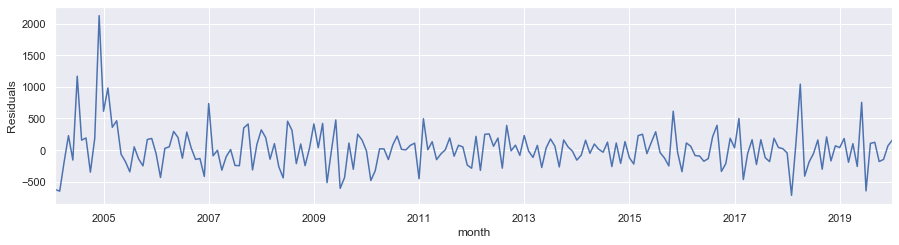

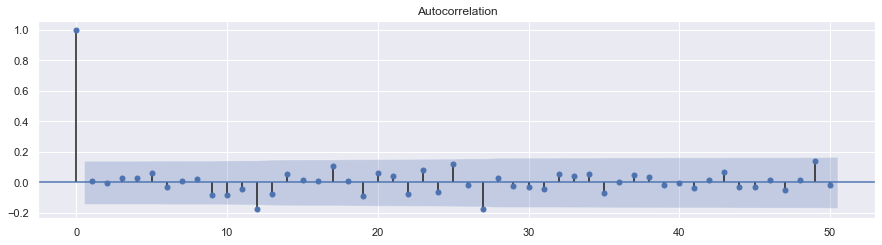

Критерий Стьюдента: p=0.437456
Критерий Дики-Фуллера: p=0.000000


In [45]:
plt.figure(figsize(15, 8))
plt.subplot(211)
best_model.resid[season + 1:].plot()
plt.ylabel('Residuals')
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[season + 1:].values.squeeze(), lags=50, ax=ax)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[season + 1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[season + 1:])[1])

* Критерий Стьюдента: $p_{value} = 0.94 >> 0.05$ - **остатки несмещены**
* Критерий Дики-Фуллера: $p_{value} = 0.00 < 0.05$ - **остатки стационарны**
* Критерий Льюнга-Бокса: $p_{value} = 0.08 > 0.05$  - **остатки неавтокоррелированы** (но неуверен)

Продемонстрируем как работает наша модель

In [46]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
# data['model'] = best_model.fittedvalues

C:\Users\tsark\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


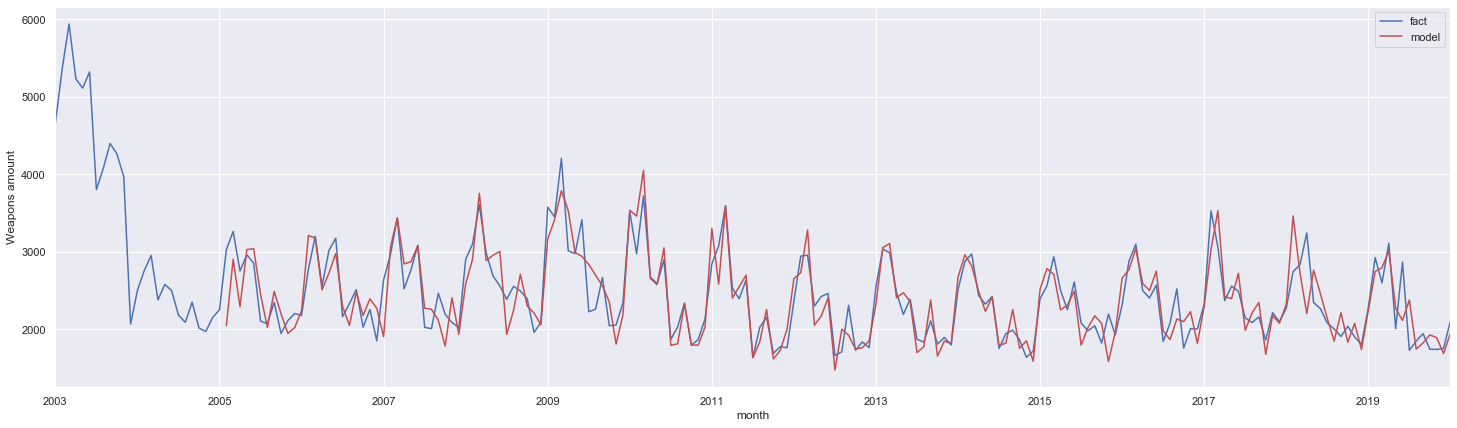

In [47]:
plt.figure(figsize(25, 7))
data.amount.plot(color='b', label='fact')
data.model[2*season + 1:].plot(color='r', label='model')
plt.ylabel('%s amount' % CATEGORY)
plt.legend()
plt.show()

#### Средняя ошибка аппроксимации

In [48]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [49]:
# я не буду учитывать первые 12 значений, потому что они заведомо сильно различаются,
# так как на них модель подбирает первые параметры
print('Средняя ошибка аппроксимации: %.2f%%' % mape(data.amount[season + 1:], data.model[season + 1:]))

Средняя ошибка аппроксимации: 9.55%


## Прогноз

Перед тем как прогнозировать, узнай количество записей в `data` и также последнюю дату, от неё и прогнозируем

In [50]:
data2 = data[['amount']]
count = data2.shape[0] - 1
how_much = 12

In [51]:
date_list = [datetime.datetime.strptime("2020-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(how_much)]
future = pd.DataFrame(index=date_list, columns= data2.columns)

In [52]:
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=count, end=count+how_much), lmbda)

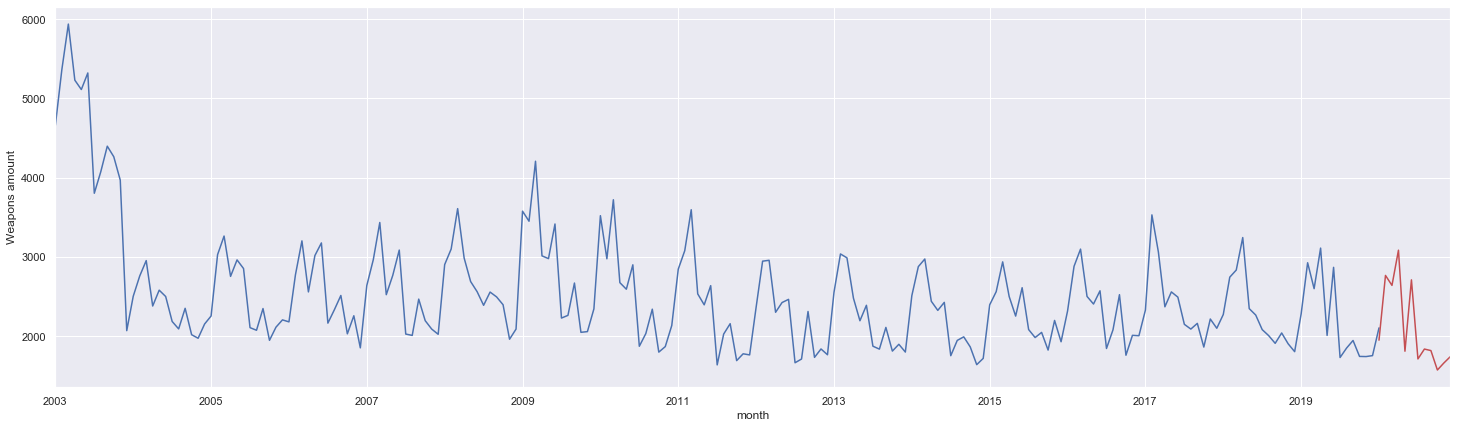

In [53]:
plt.figure(figsize(25, 7))
data.amount.plot(color='b')
data2.forecast.plot(color='r')
plt.ylabel('%s amount' % CATEGORY)
plt.show()

In [54]:
data2[['forecast']].tail(how_much)

,forecast
2020-01-01,1948.919758
2020-02-01,2766.024733
2020-03-01,2640.358385
2020-04-01,3084.472605
2020-05-01,1809.624674
2020-06-01,2710.087205
2020-07-01,1712.183960
2020-08-01,1836.807027
2020-09-01,1817.632732
2020-10-01,1572.475415
